# 02 Graph Construction

This notebook builds and saves three graph objects in `../data/processed/graphs` using processed features from `../data/processed/features`.

- **2.1 Homogeneous graph (Model 1)**: queen contiguity of polygons → PyG `Data` → `homo.pt`
- **2.2 Heterogeneous street graph (Model 2)**: contiguity + 15-min street-accessibility metapaths (walk) → PyG `HeteroData` → `hetero_walk.pt`
- **2.3 Heterogeneous multi-modal graph (Model 3 & 4)**: contiguity + 15-min street-accessibility metapaths (walk) + 15-min multi-modal accessibility metapaths (bus and walk) → PyG `HeteroData` → `hetero_multi.pt`

Notes:
- The polygon layer available in this case study is Output Areas (OA). We use OA as the spatial unit for graph nodes.
- `pop_weighted_centroid` is stored as WKT strings in the GeoPackage and is parsed into geometry before calling `c2g.contiguity_graph()`.
- Inter-layer connections are created using `c2g.bridge_nodes()` (proximity edges with relation name `is_nearby`).
- Naming convention in this notebook: street nodes are `street_connector`, bus stops are `bus_station`, street edges use relation `is_connected_to`, and bus edges use relation `is_next_to`.

In [ ]:
"""
# Colab setup (optional)
!git clone https://github.com/c2g-dev/city2graph-case-study.git

import os
REPO_DIR = "/content/city2graph-case-study"
os.chdir(REPO_DIR)

# delete data directory
!rm -rf /content/city2graph-case-study/data

# download data zip from Zenodo and unzip into data/
!wget -O /content/city2graph-case-study/data.zip https://zenodo.org/records/18396286/files/data.zip?download=1
!unzip -o /content/city2graph-case-study/data.zip -d /content/city2graph-case-study/

!pip install torch_geometric
!pip install city2graph

os.chdir(REPO_DIR + "/notebooks")
"""

In [2]:
from __future__ import annotations

from pathlib import Path

import geopandas as gpd
import torch
from shapely import wkt

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import city2graph as c2g

# Paths
FEATURE_DIR = Path("../data/processed/features")
GRAPH_DIR = Path("../data/processed/graphs")
GRAPH_DIR.mkdir(parents=True, exist_ok=True)

# Parameters
WALKING_SPEED_MPS = 4.8 / 3.6  # 4.8 km/h in m/s

# OA node feature columns (fixed list for this case study)
OA_FEATURE_COLS = [
    "arts_culture",
    "automotive_facility",
    "consumer_service",
    "corporate_service",
    "education",
    "entertainment",
    "food_beverage",
    "healthcare",
    "hotel_lodging",
    "industrial_service",
    "park",
    "public_service",
    "religion",
    "retail",
    "sports_fitness",
    "transportation_facility",
    "land_use_green_space",
    "land_use_residential",
    "land_use_industrial",
    "land_use_public_services",
    "land_use_transportation",
    "land_use_commercial",
    "land_use_agricultural",
    #"betweenness_centrality",
    #"closeness_centrality",
    #"degree_centrality"
]

STREET_FEATURE_COLS = [
    "betweenness_centrality",
    "closeness_centrality",
    "degree_centrality"
]

BUS_FEATURE_COLS = [
    "betweenness_centrality",
    "closeness_centrality",
    "degree_centrality"
]

In [3]:
# Load OA polygons + parse pop-weighted centroids
OA_PATH = FEATURE_DIR / "oa_with_features.gpkg"

# Load GeoDataFrame
oa_with_features = gpd.read_file(OA_PATH)

# Stored as WKT strings in this dataset
oa_with_features["pop_weighted_centroid"] = oa_with_features["pop_weighted_centroid"].map(wkt.loads)

# Use OA code as stable node identifier
oa_with_features = oa_with_features.set_index("OA21CD", drop=False)

## 2.0 Inspect OA Feature Distributions + Scaling

,min,max,mean,median,p90,p95,p99,zero_frac,skew
land_use_agricultural,0.0,1030935.307,950.238,0.000,0.000,0.000,84.045,0.987,36.606
park,0.0,6.000,0.127,0.000,0.000,1.000,2.000,0.908,5.072
arts_culture,0.0,33.000,0.275,0.000,1.000,1.000,5.770,0.880,13.037
hotel_lodging,0.0,27.000,0.321,0.000,1.000,2.000,6.000,0.870,9.367
land_use_industrial,0.0,1540174.928,5814.284,0.000,970.450,7510.295,107928.588,0.860,18.026
land_use_transportation,0.0,69901.939,789.806,0.000,956.802,2663.479,22449.200,0.846,9.993
religion,0.0,7.000,0.271,0.000,1.000,2.000,3.000,0.834,3.727
transportation_facility,0.0,34.000,0.377,0.000,1.000,2.000,5.000,0.828,12.293
sports_fitness,0.0,25.000,0.414,0.000,1.000,2.000,6.000,0.804,7.503
entertainment,0.0,47.000,0.507,0.000,1.000,2.000,9.000,0.801,11.840


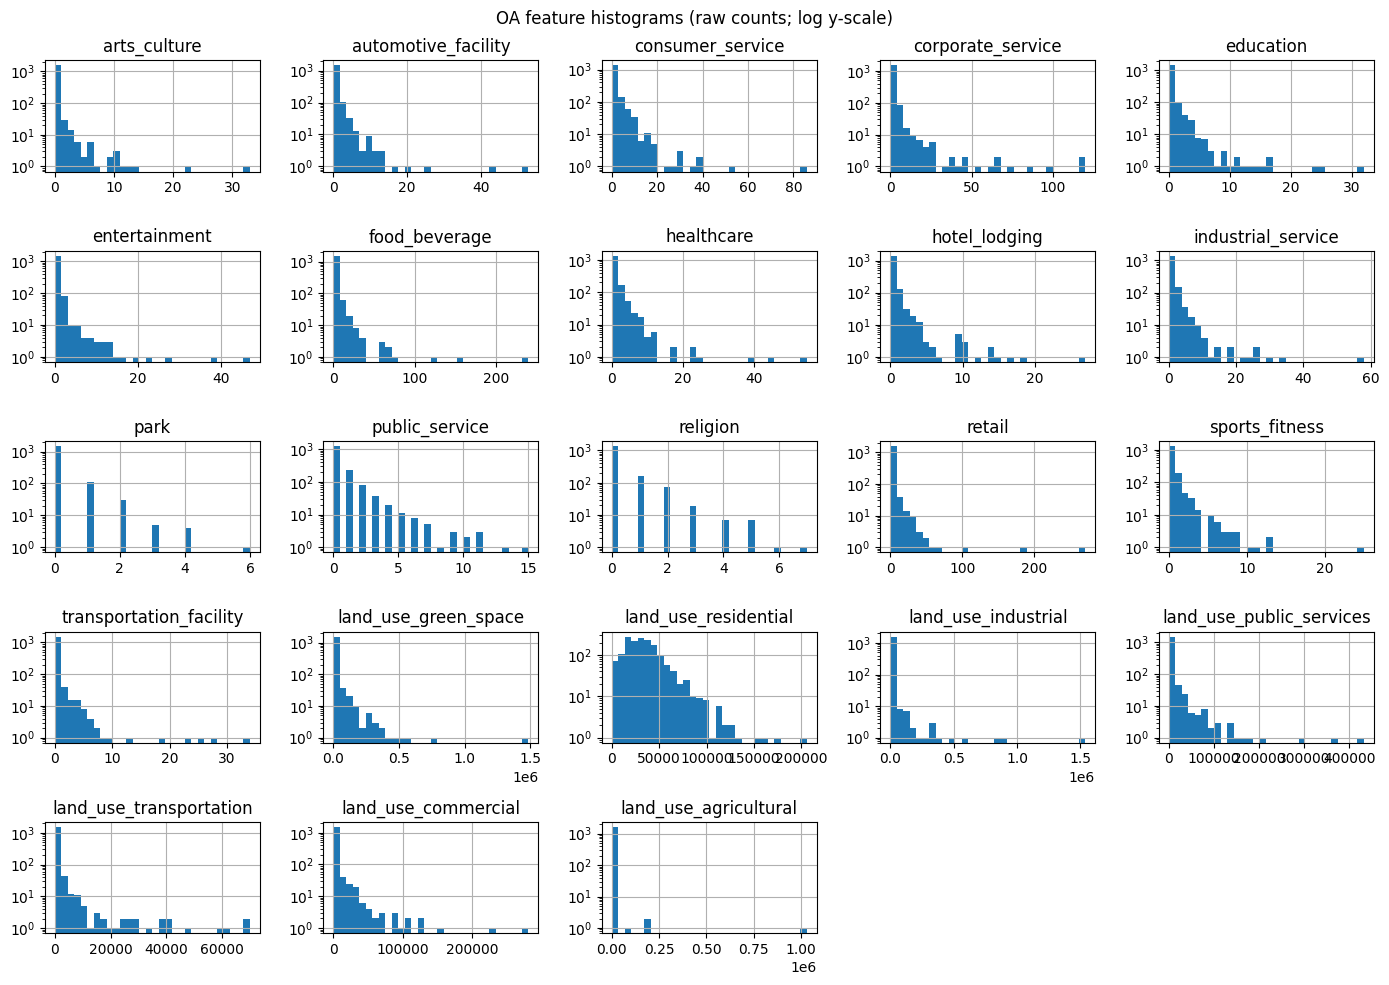

In [4]:
# --- Distribution diagnostics (raw) ---
oa_feat = oa_with_features[OA_FEATURE_COLS].copy()
oa_feat = oa_feat.apply(pd.to_numeric, errors="coerce")

if oa_feat.isna().any().any():
    bad_cols = oa_feat.columns[oa_feat.isna().any()].tolist()
    raise ValueError(f"Found NaNs after coercing OA features to numeric: {bad_cols}")

min_val = float(oa_feat.min().min())
if min_val < 0:
    raise ValueError(
        f"Expected non-negative OA features (counts), but found min={min_val}. "
        "If these aren’t counts, we should revisit the scaling choice."
    )

dist = pd.DataFrame(index=OA_FEATURE_COLS)
dist["min"] = oa_feat.min()
dist["max"] = oa_feat.max()
dist["mean"] = oa_feat.mean()
dist["median"] = oa_feat.median()
dist["p90"] = oa_feat.quantile(0.90)
dist["p95"] = oa_feat.quantile(0.95)
dist["p99"] = oa_feat.quantile(0.99)
dist["zero_frac"] = (oa_feat == 0).mean()
dist["skew"] = oa_feat.skew(numeric_only=True)

display(dist.sort_values(["zero_frac", "skew"], ascending=False).round(3))

# Quick visual: raw histograms (log y to show tails)
_ = oa_feat.hist(bins=30, figsize=(14, 10))
import matplotlib.pyplot as plt
for ax in plt.gcf().axes:
    ax.set_yscale("log")
plt.suptitle("OA feature histograms (raw counts; log y-scale)")
plt.tight_layout()
plt.show()

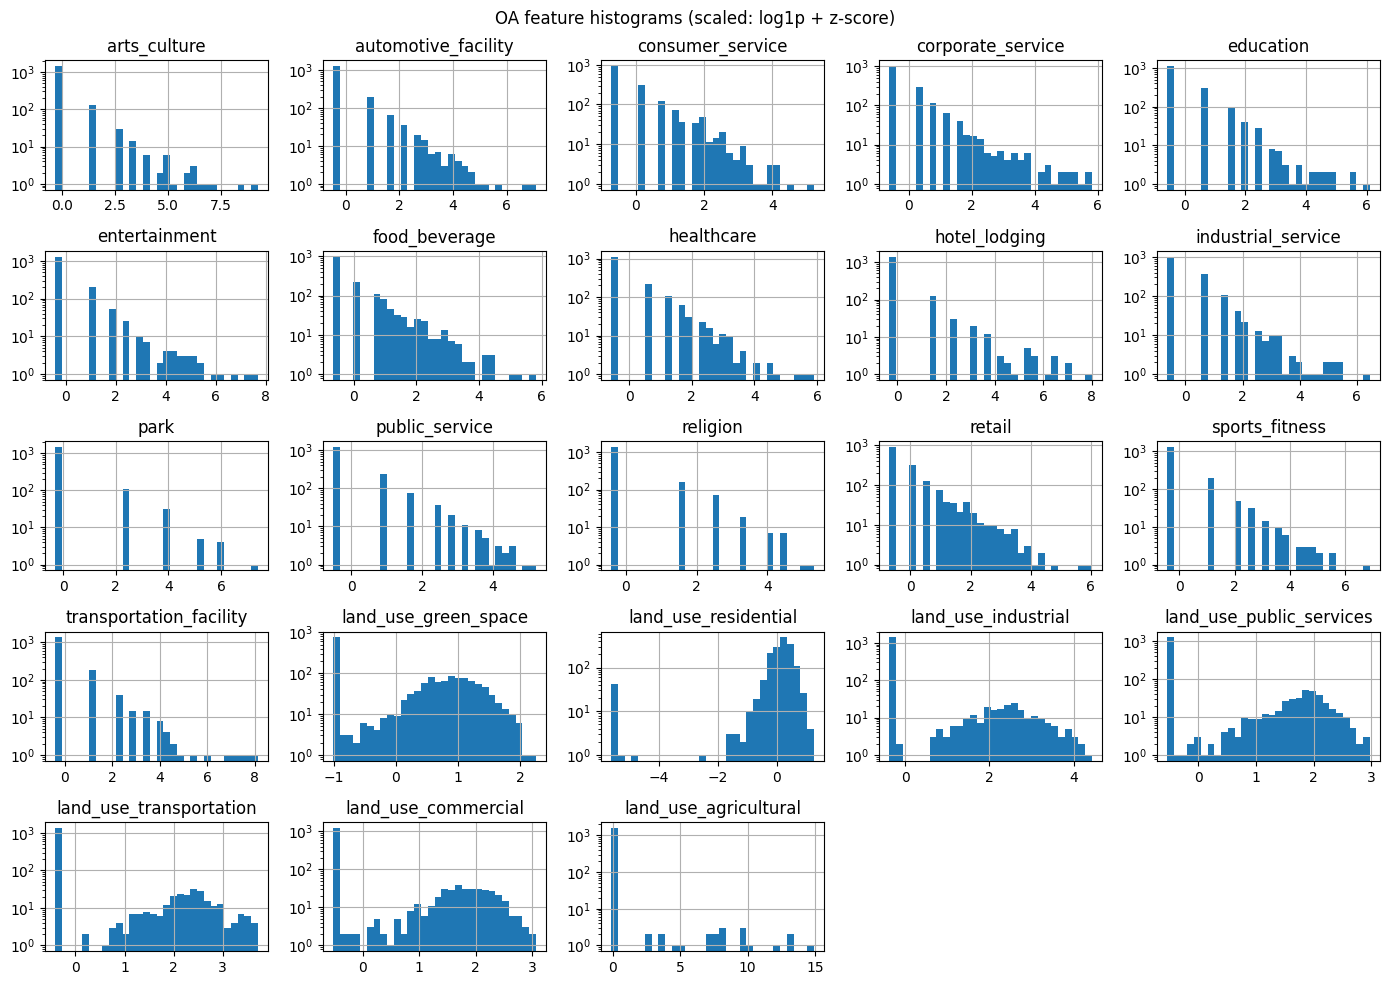

In [5]:
# --- Apply scaling and persist back onto `oa` ---
SCALING_METHOD = "log1p+zscore"

scaler = StandardScaler()

# Fit scaler on log1p-transformed counts
X = scaler.fit_transform(np.log1p(oa_feat).to_numpy(dtype=float))
oa_scaled_feat = pd.DataFrame(X, index=oa_with_features.index, columns=OA_FEATURE_COLS).astype("float32")

# Save scaling params so we can reconstruct / invert later
scaling_info = {
    "method": SCALING_METHOD,
    "feature_cols": OA_FEATURE_COLS,
    "log1p": True,
    "mean_": scaler.mean_.tolist(),
    "scale_": scaler.scale_.tolist(),
}
out_path = GRAPH_DIR / "oa_feature_scaling.json"
out_path.write_text(json.dumps(scaling_info, indent=2))

# Apply scaled features to OA GeoDataFrame (so OA node features are scaled everywhere downstream)
oa_with_features[OA_FEATURE_COLS] = oa_scaled_feat[OA_FEATURE_COLS]

# Sanity-check + histograms (scaled OA node features)
if oa_scaled_feat.isna().any().any():
    bad_cols = oa_scaled_feat.columns[oa_scaled_feat.isna().any()].tolist()
    raise ValueError(f"Found NaNs in scaled OA features: {bad_cols}")

_ = oa_scaled_feat.hist(bins=30, figsize=(14, 10))
for ax in plt.gcf().axes:
    ax.set_yscale("log")
plt.suptitle("OA feature histograms (scaled: log1p + z-score)")
plt.tight_layout()
plt.show()


##  2.1 Homogeneous graph: Queen contiguity of OA (Model 1)


In [6]:
# Construct homogeneous graph: Queen contiguity (OA polygons)
contig_nodes, contig_edges = c2g.contiguity_graph(
    oa_with_features,
    contiguity="queen",
    node_geom_col="pop_weighted_centroid",
    set_point_nodes=True,
)

# Add travel time
contig_edges["travel_time_sec"] = contig_edges["weight"].apply(lambda x: x / WALKING_SPEED_MPS)

# Convert to PyG Data object
homo_data = c2g.gdf_to_pyg(
    contig_nodes,
    contig_edges,
    node_feature_cols=OA_FEATURE_COLS,
    edge_feature_cols=["travel_time_sec"],
)

HOMO_PATH = GRAPH_DIR / "homo.pt"
torch.save(homo_data, HOMO_PATH)
print("Saved:", HOMO_PATH)

Saved: ../data/processed/graphs/homo.pt


## 2.2 Heterogeneous Street Graph (Model 2)

We build a heterogeneous graph with node types:
- `oa`: OA centroids (one per polygon)
- `street_connector`: street network nodes

Edge types:
- (`oa`, `contig`, `oa`): queen contiguity edges from 2.1
- (`street_connector`, `is_connected_to`, `street_connector`): street network edges weighted by `travel_time_sec`
- (`oa`, `is_nearby`, `street_connector`): walking connectors generated via `c2g.bridge_nodes()` (KNN, k=1 for each oa's population-weighted centroid)

Then we add 15-minute accessibility metapath edges between `oa` nodes using `add_metapaths_by_weight()` with `weight="travel_time_sec"` and `threshold=900` seconds.

In [7]:
street_nodes = gpd.read_file(FEATURE_DIR / "street_nodes.gpkg")
street_edges = gpd.read_file(FEATURE_DIR / "street_edges.gpkg")

street_nodes = street_nodes.set_index("node_id")
street_edges = street_edges.set_index(["from_node_id", "to_node_id"])

# Create nodes
hetero_nodes_walk = {
    "oa": contig_nodes,
    "street_connector": street_nodes
}

# Create edges
hetero_edges_walk = {
    ("oa", "contig", "oa"): contig_edges,
    ("street_connector", "is_connected_to", "street_connector"): street_edges
}

In [8]:
# Bridge OA and street connectors by k-NN
_, bridged_edges = c2g.bridge_nodes(
    nodes_dict=hetero_nodes_walk,
    source_node_types=["oa"],
    target_node_types=["street_connector"],
    k=1
)

# Add bridged edges to hetero_edges_walk
hetero_edges_walk.update(bridged_edges)

# Add travel time in seconds
hetero_edges_walk[('oa', 'is_nearby', 'street_connector')]["travel_time_sec"] = bridged_edges[('oa', 'is_nearby', 'street_connector')].length / WALKING_SPEED_MPS

In [9]:
# Add street accessibility metapaths between OA nodes (15 mins)
hetero_nodes_walk, hetero_edges_walk = c2g.add_metapaths_by_weight(
    nodes=hetero_nodes_walk,
    edges=hetero_edges_walk,
    weight="travel_time_sec",
    threshold=15 * 60.0,
    new_relation_name="15_min_walk",
    endpoint_type="oa",
    edge_types=[
        ("oa", "is_nearby", "street_connector"),
        ("street_connector", "is_connected_to", "street_connector"),
    ],
    directed=False,
)

array([[<Axes: title={'center': "('oa', 'contig', 'oa')"}>,
        <Axes: title={'center': "('street_connector', 'is_connected_to', 'street_connector')"}>],
       [<Axes: title={'center': "('oa', 'is_nearby', 'street_connector')"}>,
        <Axes: title={'center': "('oa', '15_min_walk', 'oa')"}>]],
      dtype=object)

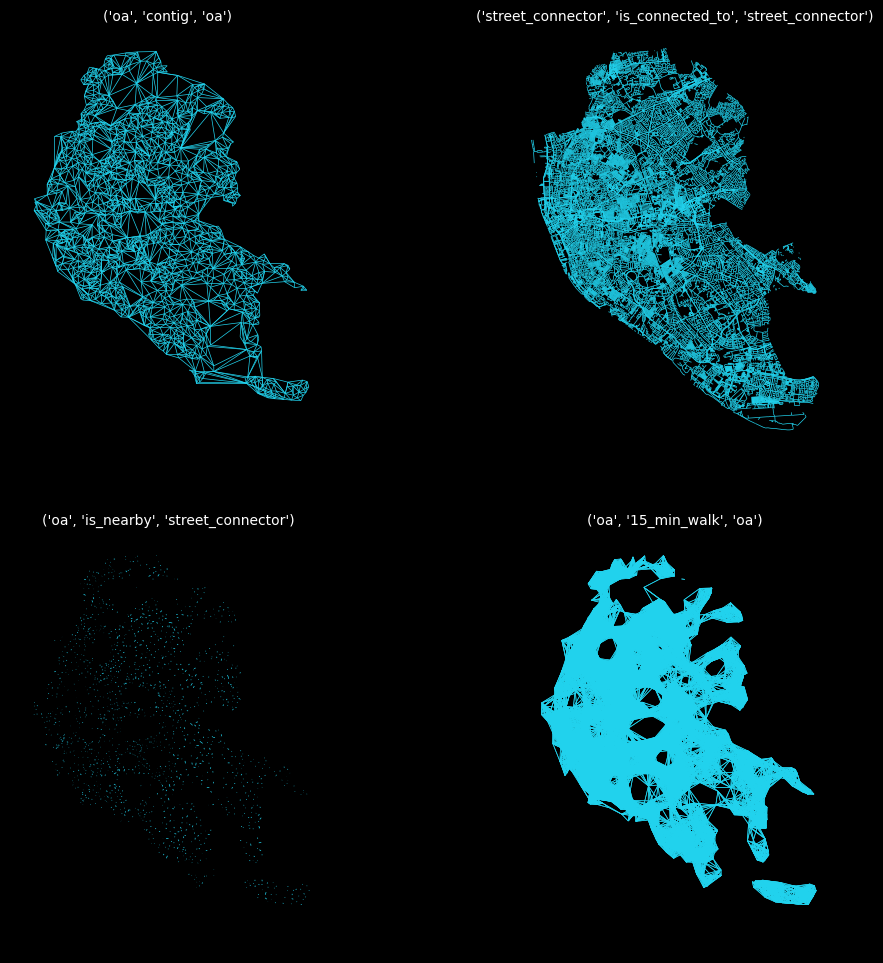

In [10]:
c2g.plot_graph(
    nodes=None,
    edges=hetero_edges_walk,
    ncols=2,
    edge_alpha=1
)

<Axes: >

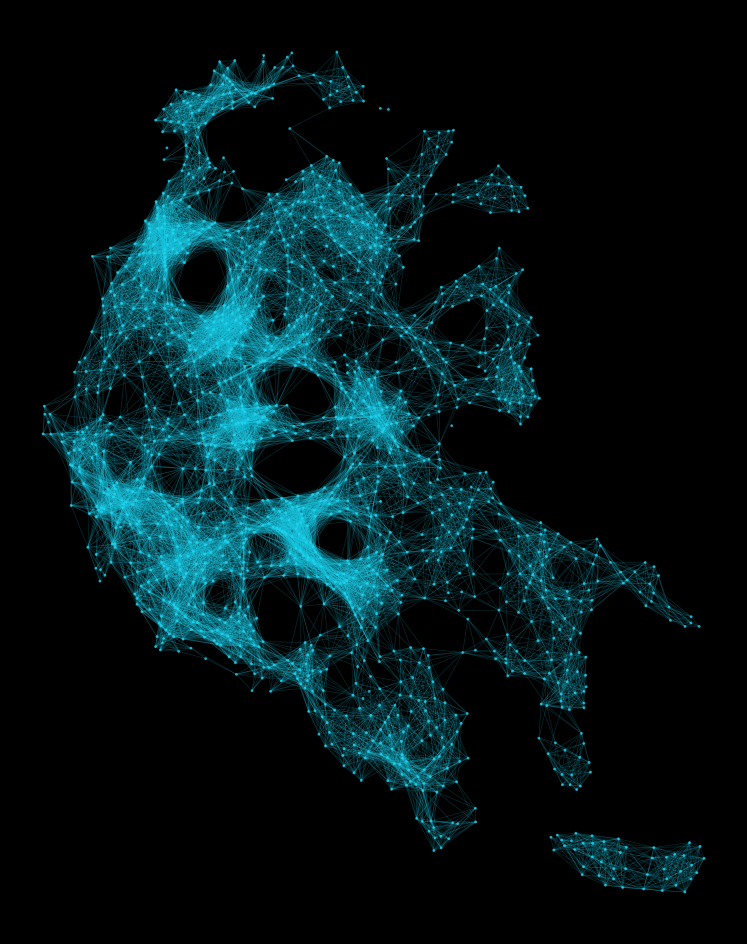

In [11]:
c2g.plot_graph(
    nodes=hetero_nodes_walk["oa"],
    edges=hetero_edges_walk[("oa", "15_min_walk", "oa")], edge_alpha=0.1)

In [12]:
HETERO_WALK_PATH = GRAPH_DIR / "hetero_walk.pt"

hetero_walk = c2g.gdf_to_pyg(
    hetero_nodes_walk,
    hetero_edges_walk,
    node_feature_cols={
        "oa": OA_FEATURE_COLS,
    },
    edge_feature_cols={
        # used for training
        ("oa", "contig", "oa"): ["travel_time_sec"],
        ("oa", "15_min_walk", "oa"): ["travel_time_sec"],

        # Not used for training, but retained for interpretation
        ('street_connector', 'is_connected_to', 'street_connector'): ["travel_time_sec"]
    }
)

torch.save(hetero_walk, HETERO_WALK_PATH)

## 2.3 Heterogeneous Graph (Model 3)

We extend Model 2 by adding a GTFS-derived bus network:
- `bus_station` nodes from `travel_summary_nodes.gpkg`
- (`bus_station`, `is_next_to`, `bus_station`) edges from `travel_summary_edges.gpkg` weighted by `travel_time_sec`

We connect bus stations to the street network via nearest-neighbor walking connectors generated with `c2g.bridge_nodes()` (`bus_station` → `street_connector`, KNN k=1).

In metapath construction we treat connectors as undirected (`directed=False`), so we do not materialize the reverse edge types (`street_connector` → `bus_station`, `street_connector` → `oa`).

Minimum travel time $\min(w^{street}, w^{bus})$ is achieved by running shortest-path on the *combined* network (street edges + bus edges + walking connectors); `add_metapaths_by_weight()` then creates OA–OA edges for reachable pairs within 15 minutes.

In [13]:
travel_summary_nodes = gpd.read_file(FEATURE_DIR / "travel_summary_nodes.gpkg")
travel_summary_edges = gpd.read_file(FEATURE_DIR / "travel_summary_edges.gpkg")

travel_summary_nodes = travel_summary_nodes.set_index("stop_id")
travel_summary_edges = travel_summary_edges.set_index(["from_stop_id", "to_stop_id"])

In [14]:
hetero_nodes_multi = {
    "oa": contig_nodes,
    "street_connector": street_nodes,
    "bus_station": travel_summary_nodes,
}

hetero_edges_multi = {
    ("oa", "contig", "oa"): contig_edges,
    ("street_connector", "is_connected_to", "street_connector"): street_edges,
    ("bus_station", "connects", "oa"): travel_summary_edges,
    ("bus_station", "is_next_to", "bus_station"): travel_summary_edges,
}

In [15]:
_, bridged_edges = c2g.bridge_nodes(
    nodes_dict=hetero_nodes_multi,
    source_node_types=["oa", "bus_station"],
    target_node_types=["street_connector"],
    k=1
)

hetero_edges_multi.update(bridged_edges)

# Add travel time in seconds
hetero_edges_multi[('oa', 'is_nearby', 'street_connector')]["travel_time_sec"] = bridged_edges[('oa', 'is_nearby', 'street_connector')].length / WALKING_SPEED_MPS
hetero_edges_multi[('bus_station', 'is_nearby', 'street_connector')]["travel_time_sec"] = bridged_edges[('bus_station', 'is_nearby', 'street_connector')].length / WALKING_SPEED_MPS

In [16]:
# Get the baseline walking edges (from Model 2)
walking_edges = hetero_edges_walk[("oa", "15_min_walk", "oa")]

# Compute the combined (Multi-modal) edges
hetero_nodes_multi, hetero_edges_multi = c2g.add_metapaths_by_weight(
    nodes=hetero_nodes_multi,
    edges=hetero_edges_multi,
    weight="travel_time_sec",
    threshold=15 * 60.0,
    new_relation_name="M_15min_combined_raw",
    endpoint_type="oa",
    edge_types=[
        ("oa", "is_nearby", "street_connector"),
        ("street_connector", "is_connected_to", "street_connector"),
        ("bus_station", "is_nearby", "street_connector"),
        ("bus_station", "is_next_to", "bus_station"),
    ],
    directed=False
)

combined_edges = hetero_edges_multi.pop(("oa", "M_15min_combined_raw", "oa"))

# Remove edges that are in walking_edges (exclude walking-only edges)
common_index = combined_edges.index.intersection(walking_edges.index)
transit_only_edges = combined_edges.drop(common_index)

# Assign to final dictionaries
hetero_edges_multi[("oa", "15_min_walk", "oa")] = walking_edges
hetero_edges_multi[("oa", "15_min_multi", "oa")] = transit_only_edges

print(f"Walking edges: {len(walking_edges)}")
print(f"Combined edges (raw): {len(combined_edges)}")
print(f"Multi-modal edges (filtered): {len(transit_only_edges)}")


Walking edges: 57036
Combined edges (raw): 192752
Multi-modal edges (filtered): 135716


array([[<Axes: title={'center': "('oa', 'contig', 'oa')"}>,
        <Axes: title={'center': "('street_connector', 'is_connected_to', 'street_connector')"}>,
        <Axes: title={'center': "('bus_station', 'connects', 'oa')"}>],
       [<Axes: title={'center': "('bus_station', 'is_next_to', 'bus_station')"}>,
        <Axes: title={'center': "('oa', 'is_nearby', 'street_connector')"}>,
        <Axes: title={'center': "('bus_station', 'is_nearby', 'street_connector')"}>],
       [<Axes: title={'center': "('oa', '15_min_walk', 'oa')"}>,
        <Axes: title={'center': "('oa', '15_min_multi', 'oa')"}>,
        <Axes: >]], dtype=object)

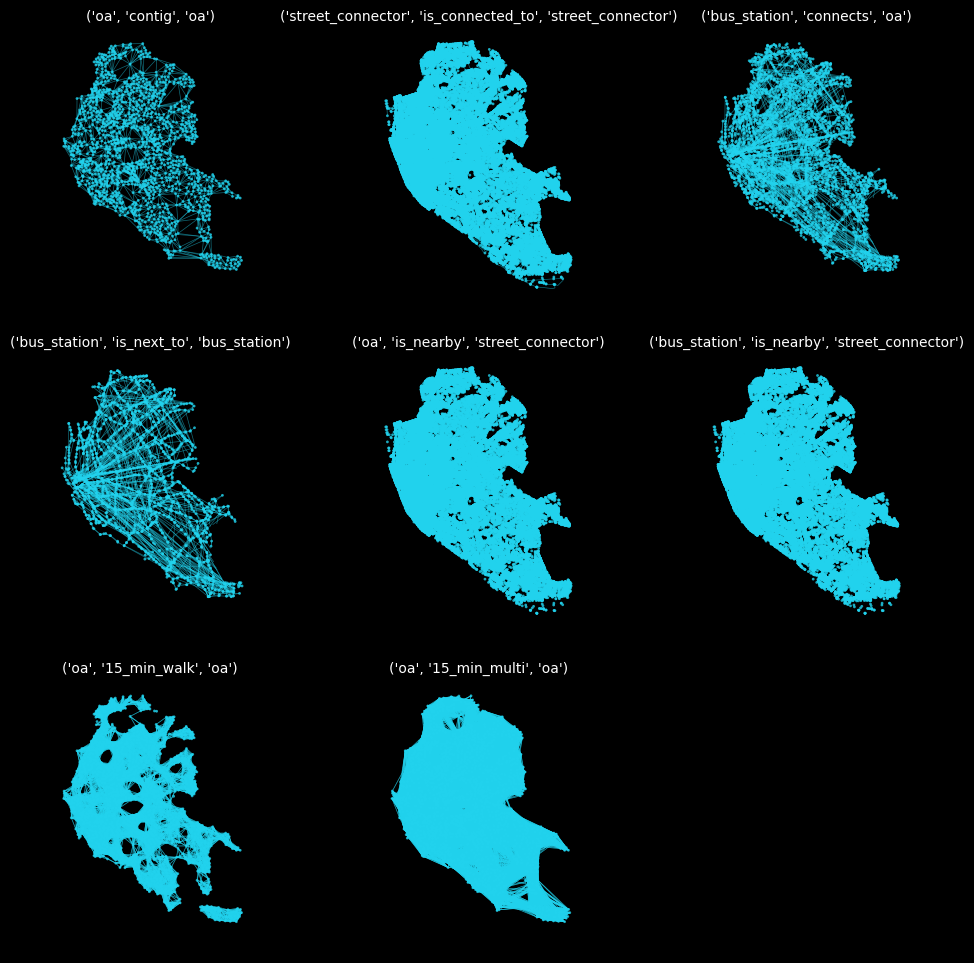

In [17]:
c2g.plot_graph(nodes=hetero_nodes_multi, edges=hetero_edges_multi)

<Axes: >

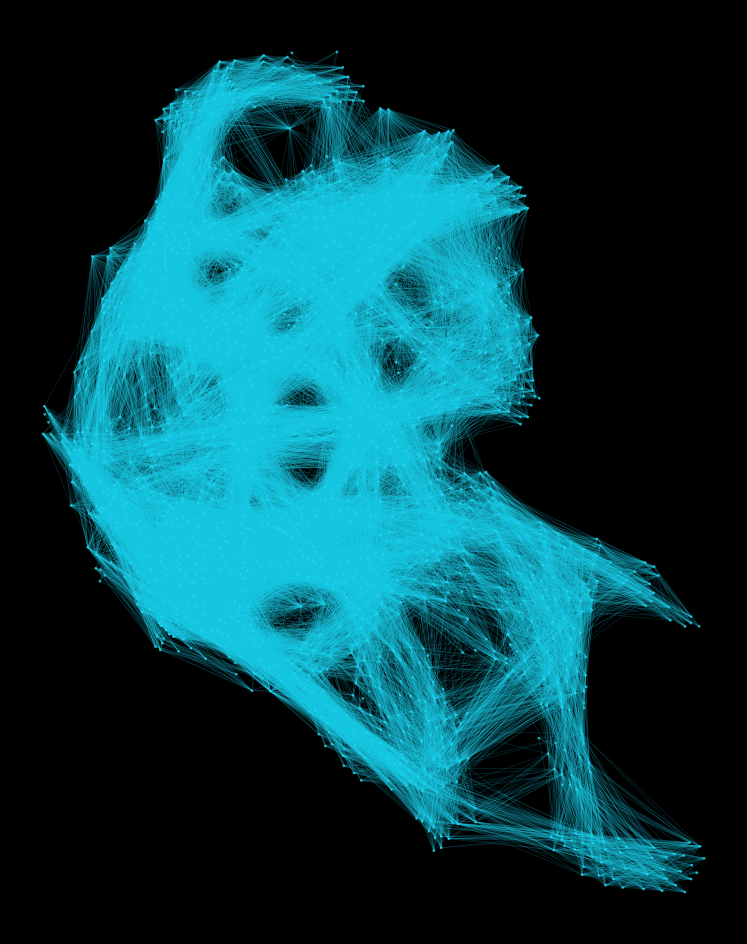

In [18]:
c2g.plot_graph(
    nodes=hetero_nodes_multi["oa"],
    edges=hetero_edges_multi[("oa", "15_min_multi", "oa")],
    edge_alpha=0.1)

In [19]:
HETERO_MULTI_PATH = GRAPH_DIR / "hetero_multi.pt"

hetero_multi = c2g.gdf_to_pyg(
    hetero_nodes_multi,
    hetero_edges_multi,
    node_feature_cols={
        "oa": OA_FEATURE_COLS,
    },
    edge_feature_cols={
        # used for training
        ("oa", "contig", "oa"): ["travel_time_sec"],
        ("oa", "15_min_walk", "oa"): ["travel_time_sec"],
        ("oa", "15_min_multi", "oa"): ["travel_time_sec"],

        # Not used for training, but retained for interpretation
        ('street_connector', 'is_connected_to', 'street_connector'): ["travel_time_sec"],
        ('bus_station', 'connects', 'oa'): ["travel_time_sec"],
        ('bus_station', 'is_next_to', 'bus_station'): ["travel_time_sec"],
        ('oa', 'is_nearby', 'street_connector'): ["travel_time_sec"],
        ('bus_station', 'is_nearby', 'street_connector'): ["travel_time_sec"],
    }
)

torch.save(hetero_multi, HETERO_MULTI_PATH)

In [20]:
HETERO_MULTI_PATH = GRAPH_DIR / "hetero_multi.pt"

hetero_multi = torch.load(HETERO_MULTI_PATH, weights_only=False)
hetero_nodes_multi, hetero_edges_multi = c2g.pyg_to_gdf(hetero_multi)

hetero_edges_multi = {k: hetero_edges_multi[k] for k in [('oa', 'contig', 'oa'), ('oa', '15_min_walk', 'oa'), ('oa', '15_min_multi', 'oa')]}